In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import lightgbm as lgb
from sklearn.kernel_ridge import KernelRidge

from multiprocessing import Lock, Manager
from multiprocessing.pool import Pool
from multiprocessing import cpu_count
import time

import seaborn

### first step: generate data ###

In [2]:
d  = 20

nrep = 10
beta = np.random.randn(d)

In [3]:
def getRandomSamplesOnNSphere(N , numberOfSamples, R = 1):
    X = np.random.default_rng().normal(size=(numberOfSamples , N))
    return R / np.sqrt(np.sum(X**2, 1, keepdims=True)) * X

In [4]:
def generate_y(x,beta):
    # x is numpy array with (n,d) ,beta is (d) and fixed
    N = x.shape[0]
    d = x.shape[1]
    e = np.random.normal(0, 0.5,size = N)
    vector = np.einsum('i,ij -> j', beta,x.T)
    fx = np.sqrt(4/10)*vector + np.sqrt(4/10)*(np.sqrt(1/2)*(vector**2-1))+ \
        np.sqrt(2/10)*(np.sqrt(1/10)*(vector**4 - 6*vector**2 + 3))
    y = fx + e
    return y

### second step: model ###

In [5]:
class dataset(Dataset):
    def __init__(self, data_tensor, data_target):
        self.data_target = data_target
        self.data_tensor = data_tensor 
    
    def __len__(self):
        return self.data_target.shape[0]

    def __getitem__(self, index):
        return self.data_tensor[index], self.data_target[index]



In [8]:
class Model_1(nn.Module):
    def __init__(self, input_dim, Nd = 100, drop_rate = 0.0, ):
        super(Model_1,self).__init__()
        self.model_name = '2 layer linear nn'
        
        self.hidden_dim = Nd//input_dim
        
        self.linear1 = nn.Linear(input_dim,self.hidden_dim,bias=False)
        self.act = nn.ReLU()

        # torch.set_num_threads(1)

#         for p in self.linear1.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)
#         for p in self.linear2.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)


    def forward(self,x):

        x_signal = self.linear1(x)
        x_signal = self.act(x_signal)
        out = self.linear2(x_signal)

        return out

In [6]:
class Model_2(nn.Module):
    def __init__(self, input_dim, Nd = 100, drop_rate = 0.0, ):
        super(Model_2,self).__init__()
        self.model_name = '2 layer linear nn'
        
        self.hidden_dim = Nd//input_dim
        
        self.linear1 = nn.Linear(input_dim,self.hidden_dim,bias=False)
        self.act = nn.ReLU()

        # torch.set_num_threads(1)

#         for p in self.linear1.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)
#         for p in self.linear2.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)


    def forward(self,x):

        x_signal = self.linear1(x)
        x_signal = self.act(x_signal)

        out = x_signal @ torch.FloatTensor([[1 if x%2==0 else -1 for x in range(x_signal.shape[1])]]).T

        return out

In [17]:

result_trainingerror = np.zeros((40,20))
result_testerror = np.zeros((40,20))    

for i in range(20,60):
    x_id = i /20
    for j in range(20,40):
        y_id = j/20
        
        N = int(np.ceil(np.e**(y_id * np.log(20))))
        Nd = int(np.ceil(np.e**(x_id* np.log(20))))
        
        for nrepitition in range(nrep):
            x = getRandomSamplesOnNSphere(d,N)
            y = generate_y(x,beta)

            x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,shuffle = True)
            x_train = torch.FloatTensor(x_train)
            x_test = torch.FloatTensor(x_test)
            y_train = torch.FloatTensor(y_train).unsqueeze(1)
            y_test = torch.FloatTensor(y_test).unsqueeze(1)

            train_dataset = dataset(x_train, y_train)
            test_dataset = dataset(x_test, y_test)
            train_dataloader = DataLoader(dataset= train_dataset, 
                                        batch_size = len(x_train), 
                                        shuffle= True, 
                                        drop_last= False)
            test_dataloader = DataLoader(dataset= test_dataset, 
                                        batch_size = len(x_test), 
                                        shuffle= True, 
                                        drop_last= False)
            torch.cuda.empty_cache()

            lr = 0.01

            device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
            model = Model_1(input_dim= d, Nd = Nd,drop_rate= 0.0).to(device)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr)
            LOSS = 0
            LOSS2 = 0
            model.train()
            
            for epoch in range(500):

                for index, (x, y) in enumerate(train_dataloader):
                    if torch.cuda.is_available():
                        x = x.to(device)
                        y = y.to(device)
                    y_pred = model(x)
                    loss = criterion(y_pred,y)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            #         for p in model.parameters():
            #             # print(p.grad.norm())                 
            #             torch.nn.utils.clip_grad_norm_(p, 10)  
            #         optimizer.step()
            LOSS += loss
            model.eval()
            loss2 = criterion(model(x_test), y_test)
            
            LOSS2 += loss2
            
        training_error = LOSS /nrep
        test_error = LOSS2 /nrep
        
        result_trainingerror[i-20][j-20] = training_error
        result_testerror[i-20][j-20] = test_error
        
        print('Nd: %d, N: %d,trainingerror: %f, testerror: %f'%(Nd,N, training_error, test_error))
        
    np.save('./result/trainingerror.npy',result_trainingerror)
    np.save('./result/testerror.npy',result_testerror)    
         




Nd: 20, N: 20,trainingerror: 0.000405, testerror: 0.091871
Nd: 20, N: 24,trainingerror: 0.100220, testerror: 0.044182
Nd: 20, N: 27,trainingerror: 0.224590, testerror: 0.054484
Nd: 20, N: 32,trainingerror: 0.014981, testerror: 0.271509
Nd: 20, N: 37,trainingerror: 0.006470, testerror: 0.078351
Nd: 20, N: 43,trainingerror: 0.011678, testerror: 0.190608
Nd: 20, N: 50,trainingerror: 0.017343, testerror: 0.064028
Nd: 20, N: 58,trainingerror: 0.013329, testerror: 0.095668
Nd: 20, N: 67,trainingerror: 0.074811, testerror: 0.057057
Nd: 20, N: 78,trainingerror: 0.029137, testerror: 0.026431
Nd: 20, N: 90,trainingerror: 0.026128, testerror: 0.043276
Nd: 20, N: 104,trainingerror: 0.018467, testerror: 0.022341
Nd: 20, N: 121,trainingerror: 0.024816, testerror: 0.054555
Nd: 20, N: 141,trainingerror: 0.019663, testerror: 0.041708
Nd: 20, N: 163,trainingerror: 0.039018, testerror: 0.072188
Nd: 20, N: 190,trainingerror: 0.053318, testerror: 0.074687
Nd: 20, N: 220,trainingerror: 0.084250, testerror: 

Nd: 50, N: 297,trainingerror: 0.036145, testerror: 0.043745
Nd: 50, N: 345,trainingerror: 0.092941, testerror: 0.037447
Nd: 58, N: 20,trainingerror: 0.106903, testerror: 0.060653
Nd: 58, N: 24,trainingerror: 0.003819, testerror: 0.275812
Nd: 58, N: 27,trainingerror: 0.000008, testerror: 0.203637
Nd: 58, N: 32,trainingerror: 0.003047, testerror: 0.100844
Nd: 58, N: 37,trainingerror: 0.014272, testerror: 0.713995
Nd: 58, N: 43,trainingerror: 0.035081, testerror: 0.177340
Nd: 58, N: 50,trainingerror: 0.000653, testerror: 0.135516
Nd: 58, N: 58,trainingerror: 0.009054, testerror: 0.077413
Nd: 58, N: 67,trainingerror: 0.041456, testerror: 0.035466
Nd: 58, N: 78,trainingerror: 0.014006, testerror: 0.783530
Nd: 58, N: 90,trainingerror: 0.035512, testerror: 0.075347
Nd: 58, N: 104,trainingerror: 0.016019, testerror: 0.044232
Nd: 58, N: 121,trainingerror: 0.044509, testerror: 0.050335
Nd: 58, N: 141,trainingerror: 0.023160, testerror: 0.147786
Nd: 58, N: 163,trainingerror: 0.029900, testerror: 

Nd: 141, N: 190,trainingerror: 0.003799, testerror: 0.162492
Nd: 141, N: 220,trainingerror: 0.004637, testerror: 0.076796
Nd: 141, N: 256,trainingerror: 0.007021, testerror: 0.115917
Nd: 141, N: 297,trainingerror: 0.011949, testerror: 0.097652
Nd: 141, N: 345,trainingerror: 0.015975, testerror: 0.076312
Nd: 163, N: 20,trainingerror: 0.000000, testerror: 0.037417
Nd: 163, N: 24,trainingerror: 0.000000, testerror: 0.035233
Nd: 163, N: 27,trainingerror: 0.000000, testerror: 0.068456
Nd: 163, N: 32,trainingerror: 0.000000, testerror: 0.042432
Nd: 163, N: 37,trainingerror: 0.000000, testerror: 0.025490
Nd: 163, N: 43,trainingerror: 0.000000, testerror: 0.054384
Nd: 163, N: 50,trainingerror: 0.000000, testerror: 0.045232
Nd: 163, N: 58,trainingerror: 0.000000, testerror: 0.120367
Nd: 163, N: 67,trainingerror: 0.000000, testerror: 0.389862
Nd: 163, N: 78,trainingerror: 0.000000, testerror: 0.125895
Nd: 163, N: 90,trainingerror: 0.000000, testerror: 0.087667
Nd: 163, N: 104,trainingerror: 0.00

Nd: 400, N: 104,trainingerror: 0.000000, testerror: 0.115324
Nd: 400, N: 121,trainingerror: 0.000000, testerror: 0.127764
Nd: 400, N: 141,trainingerror: 0.000000, testerror: 0.131401
Nd: 400, N: 163,trainingerror: 0.000000, testerror: 0.588170
Nd: 400, N: 190,trainingerror: 0.000000, testerror: 0.094484
Nd: 400, N: 220,trainingerror: 0.000000, testerror: 0.131124
Nd: 400, N: 256,trainingerror: 0.000010, testerror: 0.186078
Nd: 400, N: 297,trainingerror: 0.000018, testerror: 0.108028
Nd: 400, N: 345,trainingerror: 0.000246, testerror: 0.170866
Nd: 465, N: 20,trainingerror: 0.000000, testerror: 0.247778
Nd: 465, N: 24,trainingerror: 0.000000, testerror: 0.035871
Nd: 465, N: 27,trainingerror: 0.000000, testerror: 0.133380
Nd: 465, N: 32,trainingerror: 0.000000, testerror: 0.069471
Nd: 465, N: 37,trainingerror: 0.000000, testerror: 0.062718
Nd: 465, N: 43,trainingerror: 0.000000, testerror: 0.063878
Nd: 465, N: 50,trainingerror: 0.000000, testerror: 0.227986
Nd: 465, N: 58,trainingerror: 0

Nd: 1142, N: 58,trainingerror: 0.000000, testerror: 1.220790
Nd: 1142, N: 67,trainingerror: 0.000000, testerror: 0.033496
Nd: 1142, N: 78,trainingerror: 0.000000, testerror: 0.065189
Nd: 1142, N: 90,trainingerror: 0.000000, testerror: 0.104392
Nd: 1142, N: 104,trainingerror: 0.000000, testerror: 0.042503
Nd: 1142, N: 121,trainingerror: 0.000000, testerror: 0.106017
Nd: 1142, N: 141,trainingerror: 0.000000, testerror: 0.221750
Nd: 1142, N: 163,trainingerror: 0.000000, testerror: 0.080945
Nd: 1142, N: 190,trainingerror: 0.000000, testerror: 0.093762
Nd: 1142, N: 220,trainingerror: 0.000000, testerror: 0.074612
Nd: 1142, N: 256,trainingerror: 0.000000, testerror: 0.081426
Nd: 1142, N: 297,trainingerror: 0.000000, testerror: 0.200997
Nd: 1142, N: 345,trainingerror: 0.000000, testerror: 0.100631
Nd: 1326, N: 20,trainingerror: 0.000000, testerror: 0.150917
Nd: 1326, N: 24,trainingerror: 0.000000, testerror: 0.030536
Nd: 1326, N: 27,trainingerror: 0.000000, testerror: 0.046151
Nd: 1326, N: 32

Nd: 3257, N: 24,trainingerror: 0.000000, testerror: 0.044534
Nd: 3257, N: 27,trainingerror: 0.000000, testerror: 0.011305
Nd: 3257, N: 32,trainingerror: 0.000000, testerror: 0.031094
Nd: 3257, N: 37,trainingerror: 0.000000, testerror: 0.135413
Nd: 3257, N: 43,trainingerror: 0.000000, testerror: 0.016575
Nd: 3257, N: 50,trainingerror: 0.000000, testerror: 0.096834
Nd: 3257, N: 58,trainingerror: 0.000000, testerror: 0.070237
Nd: 3257, N: 67,trainingerror: 0.000000, testerror: 0.279907
Nd: 3257, N: 78,trainingerror: 0.000000, testerror: 0.072731
Nd: 3257, N: 90,trainingerror: 0.000098, testerror: 0.050671
Nd: 3257, N: 104,trainingerror: 0.000000, testerror: 0.080503
Nd: 3257, N: 121,trainingerror: 0.000002, testerror: 0.133697
Nd: 3257, N: 141,trainingerror: 0.000000, testerror: 0.097425
Nd: 3257, N: 163,trainingerror: 0.000000, testerror: 0.112959
Nd: 3257, N: 190,trainingerror: 0.000000, testerror: 0.034212
Nd: 3257, N: 220,trainingerror: 0.000003, testerror: 0.200925
Nd: 3257, N: 256,t

In [ ]:

result_trainingerror = np.zeros((45,40))
result_testerror = np.zeros((45,40))    

for i in range(20,65):
    x_id = i /20
    for j in range(20,60):
        y_id = j/20
        
        N = int(np.ceil(np.e**(y_id * np.log(20))))
        Nd = int(np.ceil(np.e**(x_id* np.log(20))))
        
        for nrepitition in range(nrep):
            x = getRandomSamplesOnNSphere(d,N)
            y = generate_y(x,beta)

            x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,shuffle = True)
            x_train = torch.FloatTensor(x_train)
            x_test = torch.FloatTensor(x_test)
            y_train = torch.FloatTensor(y_train).unsqueeze(1)
            y_test = torch.FloatTensor(y_test).unsqueeze(1)

            train_dataset = dataset(x_train, y_train)
            test_dataset = dataset(x_test, y_test)
            train_dataloader = DataLoader(dataset= train_dataset, 
                                        batch_size = len(x_train), 
                                        shuffle= True, 
                                        drop_last= False)
            test_dataloader = DataLoader(dataset= test_dataset, 
                                        batch_size = len(x_test), 
                                        shuffle= True, 
                                        drop_last= False)
            torch.cuda.empty_cache()

            lr = 0.01

            device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
            model = Model_1(input_dim= d, Nd = Nd,drop_rate= 0.0).to(device)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr)
            LOSS = 0
            LOSS2 = 0
            model.train()
            
            for epoch in range(500):

                for index, (x, y) in enumerate(train_dataloader):
                    if torch.cuda.is_available():
                        x = x.to(device)
                        y = y.to(device)
                    y_pred = model(x)
                    loss = criterion(y_pred,y)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            #         for p in model.parameters():
            #             # print(p.grad.norm())                 
            #             torch.nn.utils.clip_grad_norm_(p, 10)  
            #         optimizer.step()
            LOSS += loss
            model.eval()
            loss2 = criterion(model(x_test), y_test)
            
            LOSS2 += loss2
            
        training_error = LOSS /nrep
        test_error = LOSS2 /nrep
        
        result_trainingerror[i-45][j-20] = training_error
        result_testerror[i-45][j-20] = test_error
        
        print('Nd: %d, N: %d,trainingerror: %f, testerror: %f'%(Nd,N, training_error, test_error))
        
    np.save('./result2/trainingerror1.npy',result_trainingerror)
    np.save('./result2/testerror1.npy',result_testerror)    
         


Nd: 20, N: 20,trainingerror: 0.001053, testerror: 0.036682
Nd: 20, N: 24,trainingerror: 0.009178, testerror: 0.012811
Nd: 20, N: 27,trainingerror: 0.000005, testerror: 0.119510
Nd: 20, N: 32,trainingerror: 0.293504, testerror: 0.251216
Nd: 20, N: 37,trainingerror: 0.017936, testerror: 0.086917
Nd: 20, N: 43,trainingerror: 0.034691, testerror: 0.024766
Nd: 20, N: 50,trainingerror: 0.048473, testerror: 0.057220
Nd: 20, N: 58,trainingerror: 0.019655, testerror: 0.060402
Nd: 20, N: 67,trainingerror: 0.025877, testerror: 0.057659
Nd: 20, N: 78,trainingerror: 0.030338, testerror: 0.083842
Nd: 20, N: 90,trainingerror: 0.021604, testerror: 0.057275
Nd: 20, N: 104,trainingerror: 0.094741, testerror: 0.126606
Nd: 20, N: 121,trainingerror: 0.021698, testerror: 0.041966
Nd: 20, N: 141,trainingerror: 0.097946, testerror: 0.052123
Nd: 20, N: 163,trainingerror: 0.114031, testerror: 0.098510
Nd: 20, N: 190,trainingerror: 0.043662, testerror: 0.221343
Nd: 20, N: 220,trainingerror: 0.048497, testerror: 

In [144]:
result_trainingerror = np.load('./result/trainingerror2.npy')
result_testerror = np.load('./result/testerror2.npy')

In [145]:
result_trainingerror[np.isnan(result_trainingerror)] = 0
result_testerror[np.isnan(result_testerror)] = 0.05

Text(0.5, 1.0, 'training error')

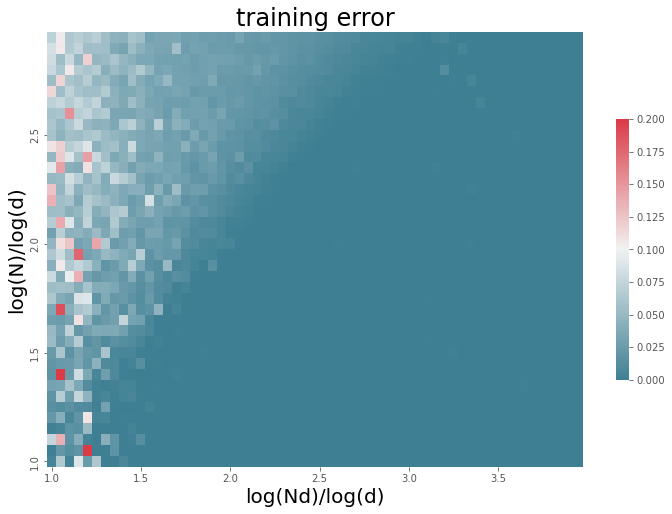

In [98]:
from matplotlib import ticker
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(12, 8))

xxs = pd.DataFrame(result_trainingerror.T,index = [x/20+1 for x in list(range(result_trainingerror.shape[1]))],
            columns = [x/20+1 for x in list(range(result_trainingerror.shape[0]))])

seaborn.heatmap(xxs, cmap=cmap,vmin = 0,vmax = 0.2,
            linewidths=.0001, cbar_kws={"shrink": 0.6},xticklabels=10,yticklabels=10)

ax.invert_yaxis()

ax.set_ylabel('log(N)/log(d)',fontsize=20, color='k')

ax.set_xlabel('log(Nd)/log(d)',fontsize=20, color='k')

plt.title('training error', fontsize = 24,color = 'k')

Text(0.5, 1.0, 'test error')

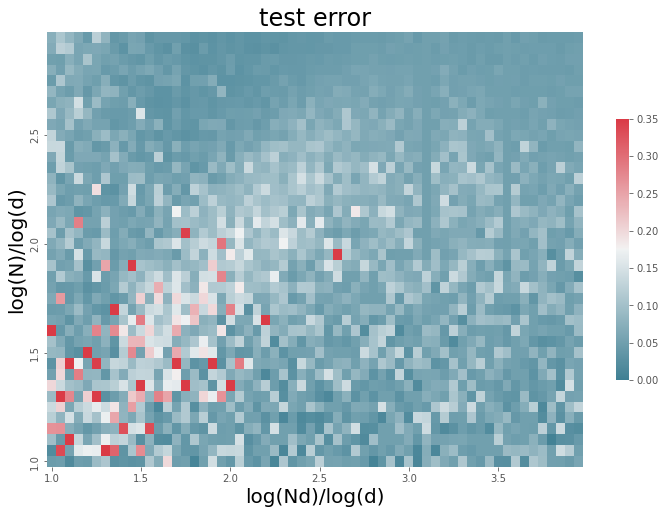

In [150]:
from matplotlib import ticker
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(12, 8))

xxss = pd.DataFrame(result_testerror.T,index = [x/20+1 for x in list(range(result_testerror.shape[1]))],
            columns = [x/20+1 for x in list(range(result_trainingerror.shape[0]))])

seaborn.heatmap(xxss, cmap=cmap,vmin = 0,vmax = 0.35,
            linewidths=.0001, cbar_kws={"shrink": 0.6},xticklabels=10,yticklabels=10)

ax.invert_yaxis()

ax.set_ylabel('log(N)/log(d)',fontsize=20, color='k')

ax.set_xlabel('log(Nd)/log(d)',fontsize=20, color='k')

plt.title('test error', fontsize = 24,color = 'k')

<AxesSubplot:>

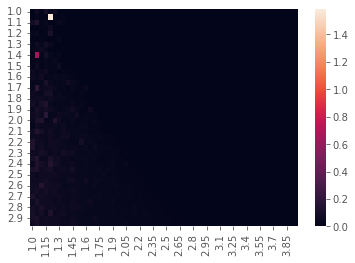

In [57]:
seaborn.heatmap(xxs)

In [65]:
?ax.xaxis.set_major_locator

In [146]:
for i in range(40,60):
    for j in range(40):
        if result_testerror[i][j]>0.15:
            result_testerror[i][j] = 0.05

In [149]:
for i in range(13,40):
    for j in range(40):
        if j< i-13:
            if result_testerror[i][j]>0.15:
                result_testerror[i][j] = 0.05

In [153]:
result_testerror[:,].shape

(60,)

In [8]:

result_trainingerror2 = np.zeros((45,3))
result_testerror2 = np.zeros((45,3))    
n_list = [46,444,4304]
for i in range(15,60):
    x_id = i /5
    for j in range(3):
        
        N = n_list[j]
        Nd = int(np.ceil(np.e**(x_id)))
        
        for nrepitition in range(nrep):
            x = getRandomSamplesOnNSphere(d,N)
            y = generate_y(x,beta)

            x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,shuffle = True)
            x_train = torch.FloatTensor(x_train)
            x_test = torch.FloatTensor(x_test)
            y_train = torch.FloatTensor(y_train).unsqueeze(1)
            y_test = torch.FloatTensor(y_test).unsqueeze(1)

            train_dataset = dataset(x_train, y_train)
            test_dataset = dataset(x_test, y_test)
            train_dataloader = DataLoader(dataset= train_dataset, 
                                        batch_size = len(x_train), 
                                        shuffle= True, 
                                        drop_last= False)
            test_dataloader = DataLoader(dataset= test_dataset, 
                                        batch_size = len(x_test), 
                                        shuffle= True, 
                                        drop_last= False)
            torch.cuda.empty_cache()

            lr = 0.01

            device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
            model = Model_2(input_dim= d, Nd = Nd,drop_rate= 0.0).to(device)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr)
            LOSS = 0
            LOSS2 = 0
            model.train()
            
            for epoch in range(500):

                for index, (x, y) in enumerate(train_dataloader):
                    if torch.cuda.is_available():
                        x = x.to(device)
                        y = y.to(device)
                    y_pred = model(x)
                    loss = criterion(y_pred,y)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            #         for p in model.parameters():
            #             # print(p.grad.norm())                 
            #             torch.nn.utils.clip_grad_norm_(p, 10)  
            #         optimizer.step()
            LOSS += loss
            model.eval()
            loss2 = criterion(model(x_test), y_test)
            
            LOSS2 += loss2
            
        training_error = LOSS /nrep
        test_error = LOSS2 /nrep
        
        result_trainingerror2[i-15][j] = training_error
        result_testerror2[i-15][j] = test_error
        
        print('Nd: %d, N: %d,trainingerror: %f, testerror: %f'%(Nd,N, training_error, test_error))
        
    np.save('./result3/trainingerror.npy',result_trainingerror2)
    np.save('./result3/testerror.npy',result_testerror2)    
         


Nd: 21, N: 46,trainingerror: 0.051512, testerror: 0.137986
Nd: 21, N: 444,trainingerror: 0.049813, testerror: 0.052021
Nd: 21, N: 4304,trainingerror: 0.063490, testerror: 0.057705
Nd: 25, N: 46,trainingerror: 0.040118, testerror: 0.092764
Nd: 25, N: 444,trainingerror: 0.059794, testerror: 0.065618
Nd: 25, N: 4304,trainingerror: 0.061354, testerror: 0.057690
Nd: 30, N: 46,trainingerror: 0.056127, testerror: 0.074534
Nd: 30, N: 444,trainingerror: 0.054632, testerror: 0.062461
Nd: 30, N: 4304,trainingerror: 0.064236, testerror: 0.062140
Nd: 37, N: 46,trainingerror: 0.044444, testerror: 0.066431
Nd: 37, N: 444,trainingerror: 0.055278, testerror: 0.066665
Nd: 37, N: 4304,trainingerror: 0.059956, testerror: 0.059484
Nd: 45, N: 46,trainingerror: 0.008186, testerror: 0.054985
Nd: 45, N: 444,trainingerror: 0.037117, testerror: 0.068246
Nd: 45, N: 4304,trainingerror: 0.046257, testerror: 0.043001
Nd: 55, N: 46,trainingerror: 0.009420, testerror: 0.099570
Nd: 55, N: 444,trainingerror: 0.041056, t

Nd: 133253, N: 444,trainingerror: 0.002905, testerror: 0.342319
Nd: 133253, N: 4304,trainingerror: 0.000000, testerror: 0.151708


In [156]:
np.ceil(4)

4.0

In [160]:
np.load('./result/trainingerror2.npy')

array([[4.55249753e-03, 1.44158979e-03, 7.52650797e-02, ...,
        8.16754401e-02, 8.37643072e-02, 7.15659857e-02],
       [6.35459274e-02, 2.04691030e-02, 1.36507645e-01, ...,
        5.32738343e-02, 1.04697391e-01, 1.04651690e-01],
       [3.37138842e-03, 1.32026123e-02, 1.73560716e-02, ...,
        7.87840188e-02, 6.46702275e-02, 6.29779771e-02],
       ...,
       [9.02083339e-17, 9.34924659e-17, 1.35605819e-16, ...,
        3.65336746e-06, 1.14787954e-05, 1.02914637e-04],
       [5.55111521e-18, 7.01193478e-18, 8.57118595e-17, ...,
        1.64825164e-04, 6.69850215e-06, 1.39008029e-04],
       [6.66188038e-17, 2.62947565e-18, 7.11071388e-17, ...,
        1.80096031e-04, 2.29380257e-05, 3.14147357e-04]])

In [162]:
list(range(1))

[0]

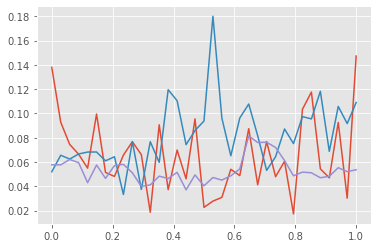

In [72]:
plt.plot(np.linspace(0,1,len(result_testerror2[0:-10,0])),result_testerror2[0:-10,0])
plt.plot(np.linspace(0,1,len(result_testerror2[0:-10,1])),result_testerror2[0:-10,1])
plt.plot(np.linspace(0,1,len(result_testerror2[0:-10,2])),result_testerror2[0:-10,2])

In [69]:
result_testerror2[-12,0] = 0.030243

In [174]:
result_testerror2[result_testerror2>1] =0

In [53]:
result_testerror2

array([[0.13798623, 0.05202109, 0.05770482],
       [0.09276383, 0.06561752, 0.05769042],
       [0.0745344 , 0.06246095, 0.06213988],
       [0.06643055, 0.06666488, 0.05948425],
       [0.05498491, 0.06824647, 0.04300108],
       [0.09956957, 0.068296  , 0.0575733 ],
       [0.51470006, 0.06101782, 0.04658533],
       [0.04817392, 0.06434979, 0.05705268],
       [0.06571525, 0.03328707, 0.05813824],
       [0.07676528, 0.07688532, 0.05115361],
       [0.06614311, 0.03744907, 0.04      ],
       [0.18670803, 0.07675575, 0.04116221],
       [0.09069713, 0.05976207, 0.0484205 ],
       [0.03725421, 0.11959021, 0.04639531],
       [0.06990279, 0.11050005, 0.05153961],
       [0.04621699, 0.07434307, 0.03711123],
       [0.09553006, 0.08600961, 0.04942258],
       [0.0226956 , 0.09381356, 0.04038538],
       [0.02783046, 0.1800869 , 0.0472815 ],
       [0.03092008, 0.09611198, 0.04516954],
       [0.0540686 , 0.06518634, 0.04869023],
       [0.04885174, 0.09628601, 0.0542675 ],
       [0.

In [210]:
dd = torch.FloatTensor([[1 if x%2==0 else -1 for x in range(list(model.linear1.parameters())[0].shape[0])]])

In [212]:
dd.shape

torch.Size([1, 6662])

In [213]:
list(model.linear1.parameters())[0].dot(dd)

RuntimeError: 1D tensors expected, but got 2D and 2D tensors

In [208]:
list(model.linear1.parameters())[0].shape

torch.Size([6662, 20])

In [216]:
list(model.linear1.parameters())[0],list(model.linear2.parameters())[0]

RuntimeError: 1D tensors expected, but got 2D and 2D tensors

In [150]:
aa1 = np.load('./result1/testerror1.npy')
aa2 = np.load('./result1/testerror2.npy')
aa3 = np.load('./result1/testerror3.npy')
result_testerror3 = np.hstack([aa1,aa2,aa3])

In [151]:
result_testerror3.shape

(45, 3)

In [155]:
aaa = pd.DataFrame(result_testerror3,index = np.linspace(0,12,len(result_testerror3[0:,2])),
            columns = ['46','444','4304'])

Text(0.5, 1.0, 'test error')

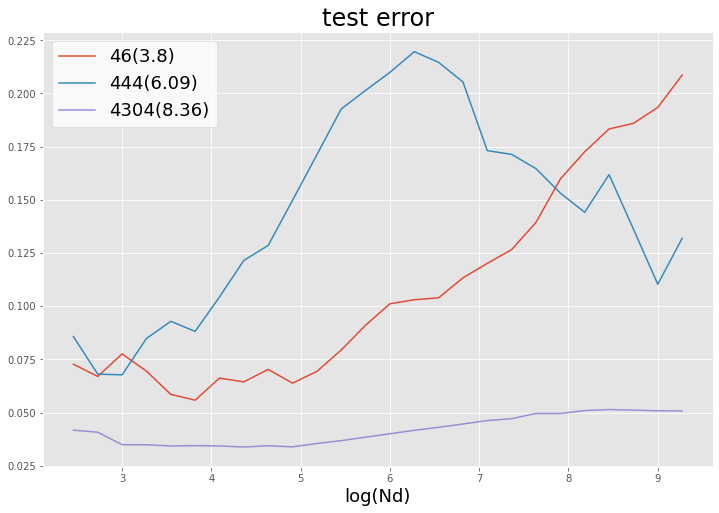

In [172]:
f, ax = plt.subplots(figsize=(12, 8))
plt.plot(aaas['46'],label = '46(3.8)')
plt.plot(aaas['444'],label = '444(6.09)')
plt.plot(aaas['4304'],label = '4304(8.36)')
plt.xlabel('log(Nd)',fontsize=18, color='k')
legend = plt.legend(loc = 'best',prop = {'size':18},frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.title('test error', fontsize = 24,color = 'k')

In [163]:
aaas = aaa.iloc[:-10,:]

In [171]:
aaas = aaas.rolling(10).mean()

In [247]:
class Model_2(nn.Module):
    def __init__(self, input_dim, Nd = 100, drop_rate = 0.0, ):
        super(Model_2,self).__init__()
        self.model_name = '2 layer linear nn'
        
        self.hidden_dim = Nd//input_dim
        
        self.linear1 = nn.Linear(input_dim,self.hidden_dim,bias=False)
        self.act = nn.ReLU()

        # torch.set_num_threads(1)

#         for p in self.linear1.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)
#         for p in self.linear2.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)


    def forward(self,x):

        x_signal = self.linear1(x)
        x_signal = self.act(x_signal)

        out = x_signal @ torch.FloatTensor([[1 if x%2==0 else -1 for x in range(x_signal.shape[1])]]).T

        return out

In [248]:

x = getRandomSamplesOnNSphere(d,N)
y = generate_y(x,beta)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,shuffle = True)
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train).unsqueeze(1)
y_test = torch.FloatTensor(y_test).unsqueeze(1)

train_dataset = dataset(x_train, y_train)
test_dataset = dataset(x_test, y_test)
train_dataloader = DataLoader(dataset= train_dataset, 
                            batch_size = len(x_train), 
                            shuffle= True, 
                            drop_last= False)
test_dataloader = DataLoader(dataset= test_dataset, 
                            batch_size = len(x_test), 
                            shuffle= True, 
                            drop_last= False)
torch.cuda.empty_cache()

lr = 0.01

device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
model = Model_2(input_dim= d, Nd = Nd,drop_rate= 0.0).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)
LOSS = 0
LOSS2 = 0
model.train()

for epoch in range(500):

    for index, (x, y) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            x = x.to(device)
            y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#         for p in model.parameters():
#             # print(p.grad.norm())                 
#             torch.nn.utils.clip_grad_norm_(p, 10)  
#         optimizer.step()
        print(loss.item())

34.28993606567383
1555.7650146484375
123.21859741210938
419.5163879394531
789.5841064453125
483.0692138671875
127.865478515625
80.68464660644531
248.4906463623047
350.48028564453125
274.5597229003906
126.07473754882812
46.492286682128906
76.76553344726562
148.59510803222656
172.84979248046875
127.610595703125
60.6148681640625
28.1835994720459
44.64131546020508
78.98208618164062
90.52326202392578
67.61502838134766
32.72420883178711
15.2528076171875
24.297752380371094
43.56603240966797
49.83079528808594
36.177127838134766
16.193246841430664
7.662380695343018
14.854629516601562
26.07140350341797
27.420127868652344
17.39017677307129
6.559381484985352
4.821476459503174
11.153579711914062
16.18702507019043
13.563544273376465
6.468675136566162
2.599186897277832
4.843420028686523
8.738639831542969
8.771720886230469
4.966913223266602
1.891846776008606
2.483325719833374
4.847112655639648
5.350930213928223
3.2899303436279297
1.231039047241211
1.3546503782272339
2.8457067012786865
3.34211969375610

8.699349574037285e-10
8.857879429946536e-10
9.321469152112627e-10
8.376606075444215e-10
6.795221052513511e-10
1.1816201350711708e-09
1.7912152872057163e-09
1.5146845999680636e-09
1.1104016595098187e-09
1.4375607371164278e-09
2.061884440962558e-09
1.2507416213836109e-09
1.3578661528512725e-09
1.858473708260533e-09
2.0038157799717737e-09
1.0412294360051533e-09
1.9960979535937895e-09
4.40433245429972e-09
3.6287930438305693e-09
2.6637299033183126e-09
1.248802616871103e-09
2.0705437364654244e-09
2.2228525686784906e-09
3.111542357103758e-09
1.3458154590750837e-09
2.115867037133512e-09
2.151772982017519e-09
2.160267742468136e-09
2.567089874006001e-09
2.558645517680702e-09
1.5061896174728417e-09
2.399427323496184e-09
2.068800686316763e-09
1.341507793739538e-09
1.0382293913480112e-09
1.8375236887635538e-09
1.8917207800228653e-09
2.4808963772215975e-09
1.3145515787016393e-09
1.4263057401819879e-09
2.7886402076404693e-09
3.456051445027697e-09
3.567072859311793e-09


In [187]:
test1 = np.load('./result2/testerror1.npy')
test2 = np.load('./result2/testerror2.npy')
test3 = np.load('./result2/testerror3.npy')
result_testerror4 = np.vstack([test1,test2,test3])

In [188]:
train1 = np.load('./result2/trainingerror1.npy')
train2 = np.load('./result2/trainingerror2.npy')
train3 = np.load('./result2/trainingerror3.npy')
result_trainingerror4 = np.vstack([train1,train2,train3])

In [189]:
result_trainingerror4[np.isnan(result_trainingerror4)] = 0
result_testerror4[np.isnan(result_testerror4)] = 0

In [190]:
result_trainingerror4[np.isnan(result_trainingerror4)] = 0
result_testerror4[np.isnan(result_testerror4)] = 0

Text(0.5, 1.0, 'training error')

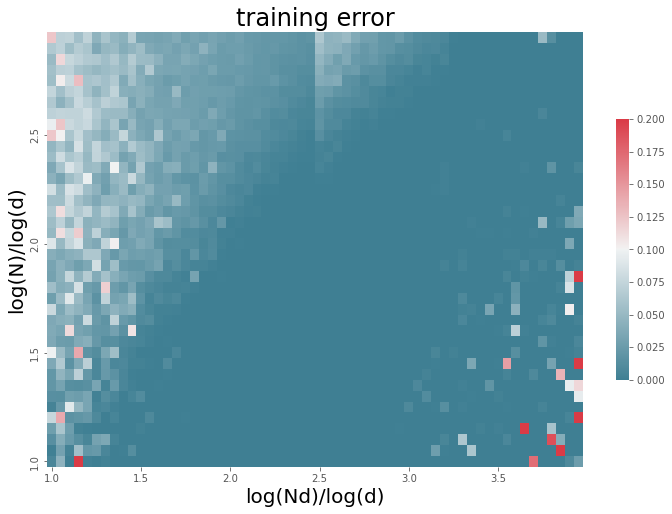

In [191]:
from matplotlib import ticker
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(12, 8))

xxs = pd.DataFrame(result_trainingerror4.T,index = [x/20+1 for x in list(range(result_trainingerror4.shape[1]))],
            columns = [x/20+1 for x in list(range(result_trainingerror4.shape[0]))])

seaborn.heatmap(xxs, cmap=cmap,vmin = 0,vmax = 0.2,
            linewidths=.0001, cbar_kws={"shrink": 0.6},xticklabels=10,yticklabels=10)

ax.invert_yaxis()

ax.set_ylabel('log(N)/log(d)',fontsize=20, color='k')

ax.set_xlabel('log(Nd)/log(d)',fontsize=20, color='k')

plt.title('training error', fontsize = 24,color = 'k')

Text(0.5, 1.0, 'test error')

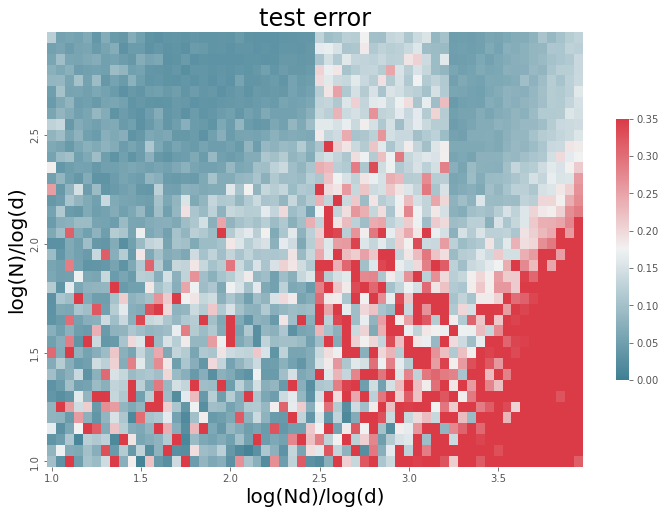

In [186]:
from matplotlib import ticker
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(12, 8))

xxss = pd.DataFrame(result_testerror4.T,index = [x/20+1 for x in list(range(result_testerror4.shape[1]))],
            columns = [x/20+1 for x in list(range(result_testerror4.shape[0]))])

seaborn.heatmap(xxss, cmap=cmap,vmin = 0,vmax = 0.35,
            linewidths=.0001, cbar_kws={"shrink": 0.6},xticklabels=10,yticklabels=10)

ax.invert_yaxis()

ax.set_ylabel('log(N)/log(d)',fontsize=20, color='k')

ax.set_xlabel('log(Nd)/log(d)',fontsize=20, color='k')

plt.title('test error', fontsize = 24,color = 'k')